In [19]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
import optuna 

In [31]:
#Best trial:
  #gamma: 4.381933972139617
  #beta: 0.15502129713848598
  #alpha: 0.5474889255066877
  #nnpu_gamma: 0.7987674959667945
  #lr: 0.0011474843720622337
  #hidden_size: 128
  #threshold: 0.19836686928889746
  #batch_size: 128
#  Dataset inladen
data = pd.read_csv("/Users/alixvanhees/Documents/HIRB THESIS /creditcard.csv")

#  Features en target
X = data.drop(columns=["Class"])
y = data["Class"]

#  Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
# Further splitting the train set into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

# Schalen
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

X_train_processed = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_processed = pd.DataFrame(X_test_scaled, columns=X.columns)
X_val_processed = pd.DataFrame(X_val_scaled, columns=X.columns)

X_train_num = X_train_scaled
X_val_num = X_val_scaled
X_train_cat = np.zeros((X_train_num.shape[0], 0))  # geen categorische features
X_val_cat = np.zeros((X_val_num.shape[0], 0))  # geen categorische features

# PU-setting: 20% van de positieve labels blijven zichtbaar
pi = 0.0017
y_train = y_train.reset_index(drop=True)
positive_indices = y_train[y_train == 1].index
label_fraction = 0.5
n_labeled = int(len(positive_indices) * label_fraction)
np.random.seed(42)
labeled_pos_indices = np.random.choice(positive_indices, size=n_labeled, replace=False)

y_train_pu = pd.Series(0, index=y_train.index)
y_train_pu.loc[labeled_pos_indices] = 1
prior = y_train.sum() / len(y_train)

#  Dataset class
class PUDatasetEmbedding(Dataset):
    def __init__(self, X_num, y_pu, y_true):
        self.X_num = X_num
        self.y_pu = y_pu
        self.y_true = y_true

    def __len__(self):
        return len(self.X_num)

    def __getitem__(self, idx):
        x_num = torch.tensor(self.X_num[idx], dtype=torch.float32)
        pu_label = torch.tensor(self.y_pu[idx], dtype=torch.float32)
        return x_num, pu_label

pu_dataset = PUDatasetEmbedding(X_train_num, y_train_pu, y_true=y_train.values)

#  nnPU + Focal loss
def focal_loss_elementwise(y_pred, y_true, gamma=4.381933972139617, alpha=0.5474889255066877):
    y_pred = torch.clamp(y_pred, 1e-7, 1. - 1e-7)
    ce = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    loss = alpha_factor * ((1 - pt) ** gamma) * ce
    return loss

def nnpu_focal_loss(y_pred, y_true, prior, gamma=4.381933972139617, alpha= 0.5474889255066877, beta=0.15502129713848598, nnpu_gamma=0.7987674959667945):
    mask_pos = y_true == 1
    mask_unl = y_true == 0

    if mask_pos.sum() == 0 or mask_unl.sum() == 0:
        return torch.tensor(0.0, requires_grad=True)

    loss_pos = focal_loss_elementwise(y_pred[mask_pos], torch.ones_like(y_pred[mask_pos]), gamma, alpha).mean()
    loss_neg_pos = focal_loss_elementwise(y_pred[mask_pos], torch.zeros_like(y_pred[mask_pos]), gamma, alpha).mean()
    loss_neg_unl = focal_loss_elementwise(y_pred[mask_unl], torch.zeros_like(y_pred[mask_unl]), gamma, alpha).mean()

    positive_risk = prior * loss_pos
    negative_risk = loss_neg_unl - prior * loss_neg_pos

    if negative_risk < -beta:
        total_loss = -nnpu_gamma * negative_risk
    else:
        total_loss = positive_risk + torch.clamp(negative_risk, min=0.0)

    return total_loss

#  Simpel NN model
class SimpleEmbeddingPUModel(nn.Module):
    def __init__(self, input_dim_numeric, hidden_size=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim_numeric, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x_num, x_cat=None):
        return self.fc(x_num)



In [32]:
#  Training
dataloader = DataLoader(pu_dataset, batch_size= 128, shuffle=True)
model = SimpleEmbeddingPUModel(input_dim_numeric=X_train_num.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0011474843720622337)

for epoch in range(10):
    model.train()
    total_loss = 0.0

    for x_num, pu_label in dataloader:
        optimizer.zero_grad()
        y_pred = torch.sigmoid(model(x_num).squeeze())
        loss = nnpu_focal_loss(y_pred, pu_label, prior=prior)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")


Epoch 1 - Loss: 0.0001
Epoch 2 - Loss: 0.0000
Epoch 3 - Loss: 0.0000
Epoch 4 - Loss: 0.0000
Epoch 5 - Loss: 0.0000
Epoch 6 - Loss: 0.0000
Epoch 7 - Loss: 0.0000
Epoch 8 - Loss: 0.0000
Epoch 9 - Loss: 0.0000
Epoch 10 - Loss: 0.0000


In [33]:

# Evaluatiemodus
model.eval()

# Zet testfeatures om naar tensor
X_test_tensor = torch.tensor(X_test_processed.values.astype(np.float32))

# Maak voorspellingen
with torch.no_grad():
    logits = model(X_test_tensor).squeeze()
    y_probs = torch.sigmoid(logits).numpy()

#  Drempel instellen
threshold = 0.19836686928889746
y_pred = (y_probs >= threshold).astype(int)

# Zet y_test om naar integer
y_true = y_test.values.astype(int)

#  Bereken evaluatiestatistieken
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)
cm = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

print("Confusion Matrix:")
print(cm)


Accuracy: 0.9848
Precision: 0.0894
Recall: 0.8446
F1-score: 0.1617
ROC AUC: 0.9584
PR AUC: 0.6679
Confusion Matrix:
[[84022  1273]
 [   23   125]]


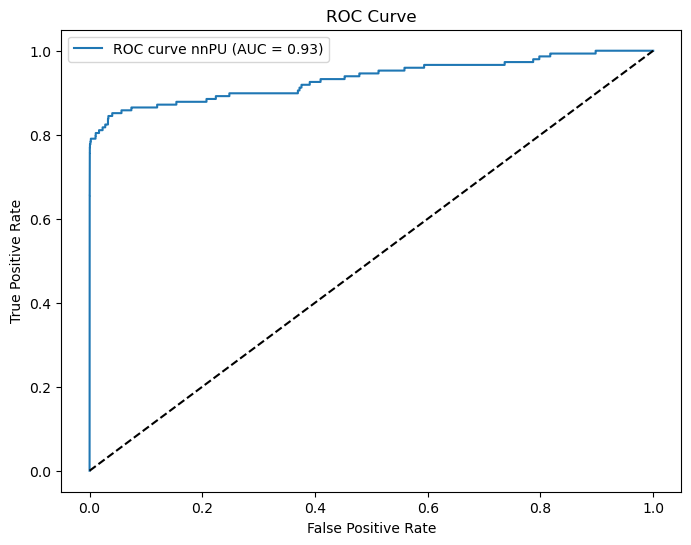

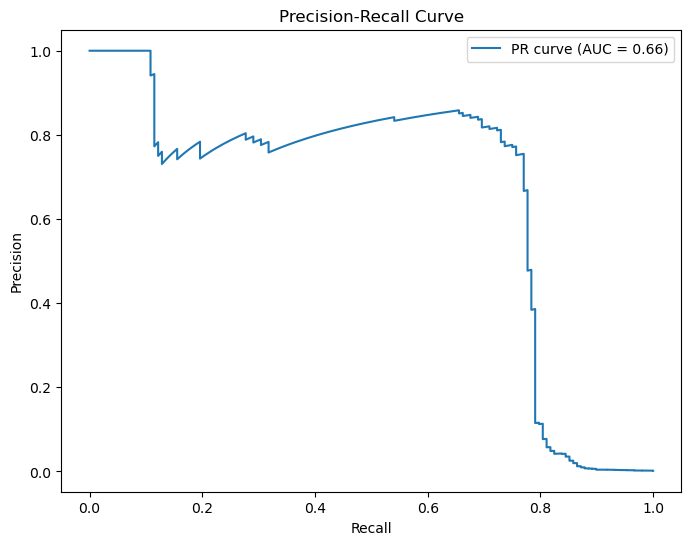

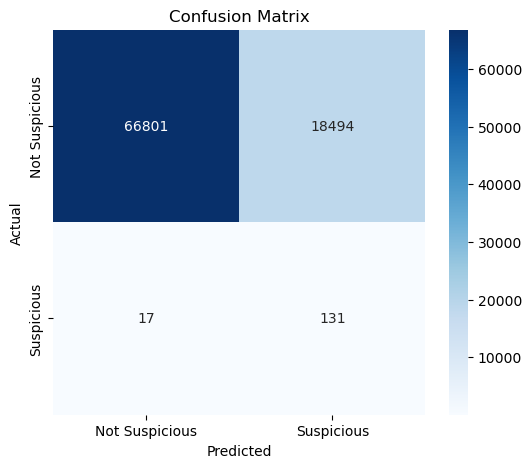

In [24]:
#  Stap 17: ROC Curve plotten
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve nnPU (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale lijn (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#  Stap 18: Precision-Recall Curve plotten
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

#  Stap 19: Confusion Matrix visualiseren
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [6]:
!pip install optuna 

In [9]:
# Precompute Validation Tensor (Efficient)
x_val_num_tensor = torch.tensor(X_val_num, dtype=torch.float32).to(device)

def objective(trial, x_val_num_tensor):
    # 🔧 Sample hyperparameters
    gamma = trial.suggest_float('gamma', 1.0, 5.0)
    beta = trial.suggest_float('beta', 0.0, 0.2)
    alpha = trial.suggest_float("alpha", 0.1, 0.9)
    nnpu_gamma = trial.suggest_float("nnpu_gamma", 0.5, 2.0)
    lr = trial.suggest_float('lr', 1e-4, 0.3)
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    threshold = trial.suggest_float('threshold', 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512, 1024])

    # 🧠 Define model
    model = SimpleEmbeddingPUModel(
        input_dim_numeric=X_train_num.shape[1],  # Only numeric input
        hidden_size=hidden_size
    ).to(device)

    # 🧪 Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 📦 Create DataLoader with Only Numeric Features
    dataset = PUDatasetEmbedding(X_train_num, y_train_pu, y_train.values)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 🔁 Training loop (shortened for tuning)
    model.train()
    for epoch in range(10):  # use fewer epochs for faster tuning
        for x_num, pu_label in loader:
            x_num, pu_label = x_num.to(device), pu_label.to(device)
            optimizer.zero_grad()
            y_probs = torch.sigmoid(model(x_num).squeeze())
            loss = nnpu_focal_loss(y_probs, pu_label, prior=pi, beta=beta, gamma=gamma, alpha=alpha, nnpu_gamma=nnpu_gamma)
            if torch.isnan(loss): 
                continue  # skip unstable batches
            loss.backward()
            optimizer.step()

    # 🔍 Evaluate on Validation Set (not Test Set)
    model.eval()
    with torch.no_grad():
        logits = model(x_val_num_tensor).squeeze()
        y_probs = torch.sigmoid(logits).cpu().numpy()
        y_probs = np.clip(y_probs, 0, 1)
        y_pred = (y_probs >= threshold).astype(int)

    # ⚡ Calculate F1 Score on Validation Set
    score = f1_score(y_val, y_pred)  # Use y_val, not y_test
    return score  # 🎯 maximize this


In [10]:
study = optuna.create_study(direction='maximize')  # we're maximizing F1
study.optimize(lambda trial: objective(trial, x_val_num_tensor), n_trials=30)

print("Best trial:")
trial = study.best_trial
for key, value in trial.params.items():
    print(f"  {key}: {value}")


[I 2025-05-13 14:28:10,017] A new study created in memory with name: no-name-892feef7-2285-4a6d-a8a9-853870ed2351
[I 2025-05-13 14:28:41,893] Trial 0 finished with value: 0.46938775510204084 and parameters: {'gamma': 1.4725597702253643, 'beta': 0.05333672289901817, 'alpha': 0.32637348234003993, 'nnpu_gamma': 1.2969529039212575, 'lr': 0.004808829503819286, 'hidden_size': 64, 'threshold': 0.22444709160958382, 'batch_size': 64}. Best is trial 0 with value: 0.46938775510204084.
[I 2025-05-13 14:29:09,670] Trial 1 finished with value: 0.40860215053763443 and parameters: {'gamma': 2.076715809519599, 'beta': 0.08759237248820467, 'alpha': 0.596299711357258, 'nnpu_gamma': 0.6150950223291755, 'lr': 0.00322982475374575, 'hidden_size': 32, 'threshold': 0.3346944311333303, 'batch_size': 1024}. Best is trial 0 with value: 0.46938775510204084.
[I 2025-05-13 14:29:37,392] Trial 2 finished with value: 0.0 and parameters: {'gamma': 1.826465475909914, 'beta': 0.14170731523645205, 'alpha': 0.6296259346937

Best trial:
  gamma: 4.381933972139617
  beta: 0.15502129713848598
  alpha: 0.5474889255066877
  nnpu_gamma: 0.7987674959667945
  lr: 0.0011474843720622337
  hidden_size: 128
  threshold: 0.19836686928889746
  batch_size: 128


In [17]:
fpr_pu, tpr_pu, _ = roc_curve(y_true, y_probs)
auc_pu = roc_auc_score(y_test, y_probs)

np.savez("roc_nnPU(FRAUDE).npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_probs)



In [18]:
np.save("preds_NNPU(FRAUDE).npy", y_pred)